<a href="https://colab.research.google.com/github/bhaweshiitk/20.C51_project/blob/main/20_C51_Graduate_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMport Libraries
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
!pip install Bio
!pip install umap-learn
from Bio import SeqIO
import umap
!pip install torchviz
!pip install tqdm
from torchviz import make_dot
from tqdm import tqdm 

     |████████████████████████████████| 269 kB 4.5 MB/s 
     |████████████████████████████████| 2.3 MB 9.4 MB/s 
     |████████████████████████████████| 88 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 38.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=5dea450f3b4236094c7f91a7550705128315e457387a4f6a0114980ad98106f7
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=546a8a6cfd0c633d4a678c6b487ba7d65743098eb76b9b5e3b8051cfd7c0c7a7
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=a3e2bb66b298b959f8a7dd36c478264050ee07b1057dabe172405acaa0c4209b
  Stored in directory: /root/.cache/pip/wheel

In [2]:
# Import data

! wget https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_annotations_v2.00.csv
! wget https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_database_v2.00.fasta

--2022-05-09 16:21:57--  https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_annotations_v2.00.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948917 (927K) [text/plain]
Saving to: ‘megares_modified_annotations_v2.00.csv’

megares_modified_an 100%[===================>] 926.68K  --.-KB/s    in 0.04s   

2022-05-09 16:21:57 (20.5 MB/s) - ‘megares_modified_annotations_v2.00.csv’ saved [948917/948917]

--2022-05-09 16:21:58--  https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_database_v2.00.fasta
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.13

### Process data


In [3]:
train_annotations = pd.read_csv("./megares_modified_annotations_v2.00.csv")
train_annotations.shape

(7868, 5)

In [4]:
train_annotations.head()

,header,type,class,mechanism,group
0,MEG_1|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
1,MEG_2|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
2,MEG_3|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
3,MEG_4|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
4,MEG_5|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S


In [5]:
train_annotations['Seq_name'] = train_annotations['header'].str.split('|').str[0:2].apply('|'.join)
train_annotations['mechanism'] = train_annotations['header'].str.split('|').str[3]

In [6]:
fasta_sequences = SeqIO.parse(open("./megares_modified_database_v2.00.fasta"),'fasta')
sequence_dict = {}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    name = "|".join((name.split("|", 2))[0:2])
    sequence_dict[name] = sequence
sequence_df = pd.DataFrame(sequence_dict.items(), columns=['Seq_name', 'Sequence'])
sequence_df.shape

(7868, 2)

In [7]:
sequence_df.head(1)

,Seq_name,Sequence
0,MEG_1|Drugs,AGAATTTGATCTTGGTTCAGATTGAACGCTGGCGGCGTGGATGAGG...


In [8]:
# Merge seq with annotation data
df = pd.merge(train_annotations[['Seq_name', 'type', 'class','mechanism','group']], 
              sequence_df, how = "inner", on = ["Seq_name"])
df.shape

(7868, 6)

In [9]:
df.head(1)

,Seq_name,type,class,mechanism,group,Sequence
0,MEG_1|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGAATTTGATCTTGGTTCAGATTGAACGCTGGCGGCGTGGATGAGG...


In [10]:
df["class"].value_counts().to_frame().rename(columns = {"class":"count"}).head()

,count
betalactams,3911
Aminoglycosides,773
Drug and biocide resistance,363
Glycopeptides,299
Fluoroquinolones,296


In [11]:
df["mechanism"].value_counts().to_frame().rename(columns = {"mechanism":"count"}).head()

,count
Class_A_betalactamases,1580
Class_C_betalactamases,950
Class_D_betalactamases,900
Class_B_betalactamases,410
Aminoglycoside_N-acetyltransferases,359


In [12]:
# Label for prediction into major class of antibiotic resistance
label_1 = ['Aminoglycosides', 'betalactams', 'Glycopeptides', 'Tetracyclines',
           'MLS', 'Fluoroquinolones', 'Trimethoprim',
           'Phenicol', 'Sulfonamides', 'Lipopeptides']

In [13]:
# Create label column containing major antibiotic drug classes. Classify all remaining drug as other.
df['labels'] = df["class"]
df.loc[~df['labels'].isin(label_1),'labels'] = "other"

In [14]:
df.labels.value_counts()

betalactams         3911
other               1547
Aminoglycosides      773
Glycopeptides        299
Fluoroquinolones     296
Tetracyclines        294
MLS                  270
Phenicol             145
Trimethoprim         135
Sulfonamides         103
Lipopeptides          95
Name: labels, dtype: int64

In [15]:
X = df.Sequence.values
y = df.labels.values
print(X.shape, y.shape)
index_to_remove = []
for (i, seq) in enumerate(X):
  if set(seq.upper())!={"A", "T", "C", "G"}:
    index_to_remove.append(i)
index_to_remove
X = np.delete(X, index_to_remove, axis=0)
y = np.delete(y, index_to_remove, axis=0)
print(X.shape, y.shape)

(7868,) (7868,)
(7819,) (7819,)


In [16]:
code = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
label_code_1 = {"betalactams":0, "Aminoglycosides":1, "Glycopeptides":2, "Fluoroquinolones":3,
                "Tetracyclines":4, "MLS":5,
                 'Trimethoprim':6,'Phenicol':7,  'Sulfonamides':8, 'Lipopeptides':9,"other":10}

In [17]:
import torch.nn.functional as F
def encode(seq, label, labels_dict):
  label_int = labels_dict[label]
  enc_seq = [code[x] for x in seq.upper()]
  return [torch.LongTensor(enc_seq[0:2000]), torch.LongTensor([label_int]), len(enc_seq)]

class SequenceDataset(Dataset):
    def __init__(self, X, y, labels_dict):
        
        self.X = X 
        self.y = y 
        self.labels_dict =labels_dict
        self.len=len(self.X)      

    def __getitem__(self, index):
        X_elem, y_elem, length_seq = encode(self.X[index], self.y[index], labels_dict=self.labels_dict)
        return F.pad(X_elem, pad=(0, 2000 - len(X_elem))), y_elem

    def __len__(self):
        return self.len

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 
train_data = SequenceDataset(X_train, y_train, labels_dict=label_code_1)
val_data = SequenceDataset(X_val, y_val, labels_dict=label_code_1)
test_data = SequenceDataset(X_test, y_test, labels_dict=label_code_1)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Simpple 1-D CNN for drug class classification

In [19]:
class cnn1d(nn.Module):
    def __init__(self, label_count = len(label_code_1)):
        super(cnn1d, self).__init__()
        embed_dim = 10
        self.embedding = nn.Embedding(5, 2*embed_dim)
        self.conv1 = nn.Conv1d(2*embed_dim, 64, kernel_size = 3, padding='same')
        self.maxpool1 = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool2 = nn.MaxPool1d(kernel_size=5)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool3 = nn.MaxPool1d(kernel_size=5)
        self.dense = nn.Sequential(nn.Linear(1024, 128),        
                             nn.ReLU(), nn.Linear(128, 64),
                             nn.ReLU(), nn.Linear(64, label_count))

    def forward(self, x, hook = True):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.embedding(x)
        x = self.conv1(x.permute(0, 2, 1))
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        if hook:   # For grad-CAM part
          h = x.register_hook(self.activations_hook)

        x = self.maxpool3(x)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        
        return x
    
    def activations_hook(self, grad): # For grad-CAM part
        self.gradients = grad

    def get_activations_gradient(self): # For grad-CAM part
        return self.gradients

    def get_activations(self, x): # For grad-CAM part
        x = self.embedding(x)
        x = self.conv1(x.permute(0, 2, 1))
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        return x

In [20]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function to train on the entire dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization 
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    batch_loss = []
    model.train() # Set model to training mode 
    train_loss = 0 
    count = 0
    for batch in dataloader:    
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        
        y_pred = model(seq)
        loss = nn.functional.cross_entropy(y_pred, label.squeeze())# fill in loss here
        train_loss += loss*len(label)
        count += len(label)
        batch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/count
    return np.array(batch_loss).mean(), train_loss.detach().cpu().numpy()


def validate(model, dataloader, device):
    
    '''
    A function to validate on the validation dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    batch_loss = []
    model.eval() # Set model to evaluation mode 
    val_loss = 0
    count = 0
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq , hook=False)
            loss = nn.functional.cross_entropy(y_pred, label.squeeze())# fill in loss here
            val_loss += loss*len(label)
            count += len(label)
            batch_loss.append(loss.item())
            # validate your model on each batch here 
        val_loss = val_loss/count     
    return np.array(batch_loss).mean(), val_loss.detach().cpu().numpy()  

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
model = cnn1d()
model = model.to(device)

In [23]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3) 

In [24]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(10):
    
    # Compute train your model on training data
    epoch_loss, train_loss = train(model, train_dataloader, optimizer,  device=0)
    
    # Validate your on validation data 
    _, val_loss = validate(model, val_dataloader, device=0) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler records the validation loss 
    # scheduler.step(val_loss)
    
    print(epoch, train_loss, val_loss)

pred_labels = []
true_labels = []
test_loss = 0
with torch.no_grad():
  model.eval()
  for batch in test_dataloader:
    seq, label = batch
    seq = seq.to(device)
    label = label.to(device)
    logits = model(seq, hook = False)
    test_loss += nn.functional.cross_entropy(logits, label.squeeze())*len(label)
    preds = logits.max(1).indices
    true_labels.extend(list(label.squeeze().detach().cpu().numpy()))
    pred_labels.extend(list(preds.squeeze().detach().cpu().numpy()))
test_loss = test_loss/len(test_data)
test_acc = (np.array(true_labels) == np.array(pred_labels)).mean()
print("Test loss is {}".format(test_loss))
print("Test Acc is {}".format(test_acc))

epoch train loss validation loss
0 1.1996944 0.9019444
1 0.720799 0.57337314
2 0.48682293 0.45903525
3 0.355816 0.4211932
4 0.2466067 0.34219813
5 0.16014591 0.38780522
6 0.1102547 0.38856953
7 0.078829795 0.41202497
8 0.0462283 0.4451167
9 0.03269447 0.478327
Test loss is 0.4271964430809021
Test Acc is 0.9111253196930946


In [25]:
# Multiple Random trail for getting a true accuracy/test loss picture
acc_list = []
test_loss_list = []
for i in tqdm(range(10)):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = i) 
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = i) 
  train_data = SequenceDataset(X_train, y_train, labels_dict=label_code_1)
  val_data = SequenceDataset(X_val, y_val, labels_dict=label_code_1)
  test_data = SequenceDataset(X_test, y_test, labels_dict=label_code_1)

  batch_size = 32
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  model = cnn1d()
  model = model.to(device)
  optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3) 
  val_loss_curve = []
  train_loss_curve = []

  for epoch in range(8):
      
      # Compute train your model on training data
      epoch_loss, train_loss = train(model, train_dataloader, optimizer,  device=0)
      
      # Validate your on validation data 
      _, val_loss = validate(model, val_dataloader, device=0) 
      
      # Record train and loss performance 
      train_loss_curve.append(epoch_loss)
      val_loss_curve.append(val_loss)
      
      # The learning rate scheduler records the validation loss 
      # scheduler.step(val_loss)
      
      # print(epoch, train_loss, val_loss)

  pred_labels = []
  true_labels = []
  test_loss = 0
  with torch.no_grad():
    model.eval()
    for batch in test_dataloader:
      seq, label = batch
      seq = seq.to(device)
      label = label.to(device)
      logits = model(seq, hook = False)
      test_loss += nn.functional.cross_entropy(logits, label.squeeze())*len(label)
      preds = logits.max(1).indices
      true_labels.extend(list(label.squeeze().detach().cpu().numpy()))
      pred_labels.extend(list(preds.squeeze().detach().cpu().numpy()))
  test_loss = test_loss/len(test_data)
  test_acc = (np.array(true_labels) == np.array(pred_labels)).mean()
  acc_list.append(test_acc)
  test_loss_list.append(test_loss.cpu().numpy())
print("Mean Test loss is {}".format(np.array(test_loss_list).mean()))
print("Mean Test Acc is {}".format(np.array(acc_list).mean()))


100%|██████████| 10/10 [02:01<00:00, 12.13s/it]

Mean Test loss is 0.4391666352748871
Mean Test Acc is 0.9102301790281329


In [26]:
np.array(test_loss_list).std(), np.array(acc_list).std()

(0.075808525, 0.008753755033311932)

## Visualization for Simple 1-D CNN Model

### Performance

In [27]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(true_labels, pred_labels)
shape = cmat.shape
cmat_sum = cmat.sum(1).reshape((-1, 1))
cmat_perc = cmat*100/cmat_sum
labels = (np.asarray(["{1:.1f}% \n {0:.0f}".format(num, perc)
                      for num, perc in zip(cmat.flatten(),
                                               cmat_perc.flatten())])).reshape(shape)

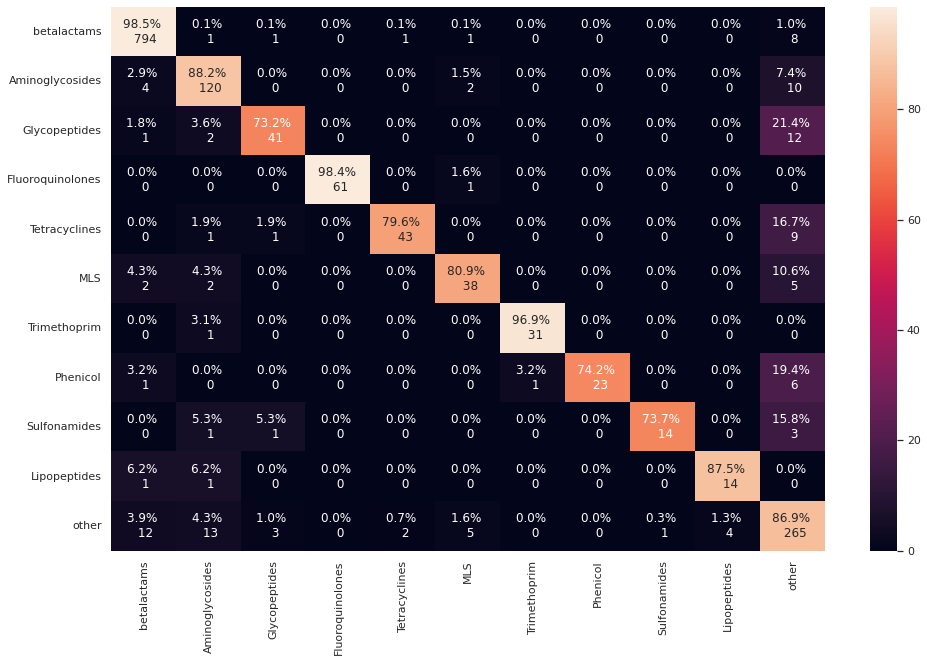

In [28]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(16,10)})

fig, ax = plt.subplots()
sns.heatmap(cmat_perc, annot=labels, fmt="",  ax=ax, yticklabels=(label_code_1.keys()),
            xticklabels=label_code_1.keys())
plt.show()

### grad-CAM for Sequence embeddings

In [29]:
import cv2

def highlight(model, seq, label, n_channels, label_dict, threshold_imp=0.15):
    """
    Highlights sub-sequences important for classification using Grad-CAM technique.

    model: Trained model
    seq: sequence
    label: ground truth label of sequence
    n_channel: no of channels
    label_dict: dictionary containing the resistant class to label mapping
    threshold_imp: Percentage of sequence to be highlighted according to Grad-CAM importance.
    :return:
    """
    code = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
    seq = seq.upper()
    resiatance_class = label
    def encode_seq(seq, label, label_dict):
      
      enc_seq = []
      for x in seq.upper():
        enc_seq.append(code[x])
      if len(enc_seq)<2000:
        enc_seq = enc_seq + [0]*(2000-len(enc_seq))
      # print(label_dict[label])

      return [torch.LongTensor(enc_seq[0:2000]), torch.LongTensor([label_dict[label]]), len(enc_seq)]


    enc_seq, label, seq_len = encode_seq(seq, label, label_dict)
    enc_seq= enc_seq.to(device)
    label = label.to(device)
    enc_seq = enc_seq.unsqueeze(dim=0)
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 1])
    activations = model.get_activations(enc_seq).detach()
    for i in range(n_channels):
      activations[:, i, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=1).squeeze()
    
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    length = len(heatmap)
    heatmap = heatmap.reshape((length, 1))
    heatmap = heatmap.tile([1, length]) # Tile the sequence in second dimension for resizing in next step.
    heatmap = cv2.resize(heatmap.detach().cpu().numpy(), (2000, 2000)) # Resize to sequence length. 
    heatmap = heatmap[:, 0] # As all resized columns are identical choose, any column (I choose 1st column)
    k=int(2000 * threshold_imp) 
    
    threshold = np.partition(heatmap.flatten(), -k)[-k] # Select the value of the jth largest elem in heatmap
    # We highlight everything larger than k.
    print("Highlighting important part of sequence in green....")
    for i in range(len(seq)):
      if i>1999:
        break
      if i%100 == 0:
        print('')
      if (heatmap[i] > threshold) :
          print("\033[92m"+ seq[i], end = '', flush=True)
      else:
          print("\033[94m"+ seq[i], end = '', flush=True)


In [30]:
# Highlighting random examples
highlight(model, X_test[0], y_test[0], n_channels=64, label_dict = label_code_1,  threshold_imp=0.1)

Highlighting important part of sequence in green....

ATGCAGAAACATGATGCATTTGCCGCCTTACGCTATAGAGATTTCTCAATTGTTACCATTAATCAATTTTGCTTAACGTTAGCAATTCTAATTCAAGAAA
TTATTGTTGCCTATTCACTCTATCAAATCACTAAAGACCCTCTGACTCTAGGTTTAATTGGACTTGCAGAAGCTATTCCTTTTATTGCTCTTTCTCTTTG
GGGTGGCTATTTTGCAGATAGATTTAATAAACAGATTATTATGAAAATCTGTTTATTTTTCTCGGTTCCTCTTCCTTTAGTGCTGTGGTCACTGTTCCAT
CTGCATGGTTTAGGTCATATCAGCGTAAATTTCCTTTCTTGGGGTATTTATGCTGTTATTTTTGGCTTAGGCACTATACGTGGGTTTTATAATCCCTCTG
CAACGTCTTTAAAACCATTTTTGATTCCTCGTGAACTGTACGCAAATGGTGCAACATGGACGACAATCGGTTGGCAAAGTGGTGTAATTATAGGGCCAAT
GCTTGGTGGTTTCATGCTTGCCTATTTAGGCCGAGAAACAAGTCTATTTAGTGTTGCGGTTTTACTTGGTATTTGTTTCATCTTAATTAACCTATTGCAT
AAGCGTACTTTTCCTAAAATTGAAACTGCTAATGTTTTAGAAAGTTTAGGAGATGGTTTCCGTTTTATCTGGAAAACTAAAATTGTTCTTTGGGCAATTT
CTCTTGATTTAGCTTCTGTTTTATTTGGTGGAGTCATCGCATTATTACCAATTTTTGCAGAAGATATCTTAAAAGTCGGTCCAGAAGGACTGGGATATTT
GCGTGCGGCGCCCTCTATTGGAGCGCTCGTCACTATGATTGCTTTGACTCGCTTTCCACCAACTCAACATGCATGGCGTAACATGCTACTTGCTGTTGCA
GGATTTGGTGTTTTCACGATTCTTTTCGCGTTCTCAA

In [31]:
# Highlighting random examples
highlight(model, X_test[1], y_test[1], n_channels=64, label_dict = label_code_1,  threshold_imp=0.1)

Highlighting important part of sequence in green....

GGAATCCCATGGTTAAAAAATCACTGCGCCAGTTCACGCTGATGGCGACGGCAACCGTCACGCTGTTGTTAGGAAGTGTGCCGCTGTATGCGCAAACGGC
GGACGTACAGCAAAAACTTGCCGAATTAGAGCGGCAGTCGGGAGGCAGACTGGGTGTGGCATTGATTAACACAGCAGATAATTCGCAAATACTTTATCGT
GCTGATGAGCGCTTTGCGATGTGCAGCACCAGTAAAGTGATGGCCGCGGCCGCGGTGCTGAAGAAAAGTGAAAGCGAACCGAATCTGTTAAATCAGCGAG
TTGAGATCAAAAAATCTGACCTTGTTAACTATAATCCGATTGCGGAAAAGCACGTCAATGGGACGATGTCACTGGCTGAGCTTAGCGCGGCCGCGCTACA
GTACAGCGATAACGTGGCGATGAATAAGCTGATTGCTCACGTTGGCGGCCCGGCTAGCGTCACCGCGTTCGCCCGACAGCTGGGAGACGAAACGTTCCGT
CTCGACGGTACCGAGCCGACGTTAAACACCGCCATTCCGGGCGATCCGCGTGATACCACTTCACCTCGGGCAATGGCGCAAACTCTGCGGAATCTGACGC
TGGGTAAAGCATTGGGCGACAGCCAACGGGCGCAGCTGGTGACATGGATGAAAGGCAATACCACCGGTGCAGCGAGCATTCAGGCTGGACTGCCTGCTTC
CTGGGTTGTGGGGGATAAAACCGGCAGCGGTGACTATGGCACCACCAACGATATCGCGGTGATCTGGCCAAAAGATCGTGCGCCGCTGATTCTGGTCACT
TACTTCACCCAGCCTCAACCTAAGGCAGAAAGCCGTCGCGATGTATTAGCGTCGGCGGCTAAAATCGTCACCGACGGTTTGTAATAGCGGAAACGGAATG
GGGAAACTCATTCCGTTTTTGTTTA

### Visualizing UMAP embeddings for 1-D CNN

In [32]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense[:-2])
model_cut

Sequential(
  (0): Embedding(5, 20)
  (1): Conv1d(20, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
)

In [33]:
embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

     
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        


In [34]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5629, 64), (5629,))

In [35]:
label_value = [list(label_code_1.keys())[list(label_code_1.values()).index(p)] for p in label_list]

In [36]:
df_embedding = pd.DataFrame(data = (embedding_list))
df_embedding.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-4.046002,-5.139328,-5.520222,-2.784192,-2.419919,-0.199652,-0.938983,6.775614,-4.803934,-3.870687,...,1.527025,-6.081594,0.798584,-2.984462,-6.936555,2.976339,2.129593,-3.47765,-6.470965,-3.478547


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


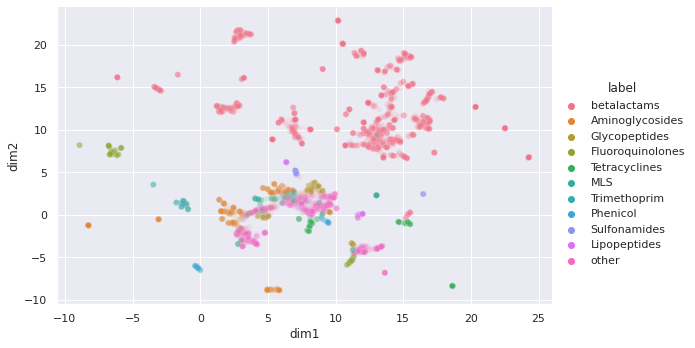

In [37]:
fit = umap.UMAP()
reduced_embedding = fit.fit_transform(df_embedding)
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["label"] = np.array(label_value)
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='label', hue_order=label_code_1.keys(), aspect=1.61, alpha = 0.1)
plt.show()

# Multitask Learning (Joint Class and Mechanism of Antibiotic Resistance Prediction)

In [38]:
# Creating mechanism label for known important antibiotic resistance mechanism
df["labels_2"] = "other"
df.loc[(df['mechanism'].str.contains("nucleotidyltransferases")),'labels_2'] = "nucleotidyltransferases"
df.loc[(df['mechanism'].str.contains("methyltransferases")),'labels_2'] = "methyltransferases"
df.loc[(df['mechanism'].str.contains("phosphotransferases")),'labels_2'] = "phosphotransferases"
df.loc[(df['mechanism'].str.contains("acetyltransferases")),'labels_2'] = "acetyltransferases"
df.loc[(df['mechanism'].str.contains("Quinolone_resistance_protein_Qnr")),
       'labels_2'] = "Quinolone_resistance_protein_Qnr"
df.loc[(df['mechanism'].str.contains("Dihydrofolate_reductase")),'labels_2'] = "Dihydrofolate_reductase"
df.loc[(df['mechanism'].str.contains("Tetracycline_resistance_ribosomal_protection_proteins")),
       'labels_2'] = "Tetracycline_resistance_ribosomal_protection_proteins"
df.loc[(df['mechanism'].str.contains("efflux_pump")),'labels_2'] = "efflux_pump"
df.loc[(df['mechanism'].str.contains("Fluoroquinolone-resistant_DNA_topoisomerases")),
       'labels_2'] = "Fluoroquinolone-resistant_DNA_topoisomerases"
df.loc[(df['mechanism'] == "Class_A_betalactamases"),'labels_2'] = "Class_A_betalactamases"
df.loc[(df['mechanism'] == "Class_B_betalactamases"),'labels_2'] = "Class_B_betalactamases"
df.loc[(df['mechanism'] == "Class_C_betalactamases"),'labels_2'] = "Class_C_betalactamases"
df.loc[(df['mechanism'] == "Class_D_betalactamases"),'labels_2'] = "Class_D_betalactamases"
label_code_2 = {}
labels_2 = ["nucleotidyltransferases", "methyltransferases", "phosphotransferases",
            "acetyltransferases", "Quinolone_resistance_protein_Qnr", "Dihydrofolate_reductase", "efflux_pump",
            "Tetracycline_resistance_ribosomal_protection_proteins", 
            "Fluoroquinolone-resistant_DNA_topoisomerases",
            "Class_A_betalactamases", "Class_B_betalactamases", "Class_C_betalactamases","Class_D_betalactamases",
            "other"]
for (i, elem) in enumerate(labels_2):
  label_code_2[elem] = i

In [39]:
df.labels_2.value_counts()

other                                                    1642
Class_A_betalactamases                                   1580
Class_C_betalactamases                                    950
Class_D_betalactamases                                    900
efflux_pump                                               826
acetyltransferases                                        445
Class_B_betalactamases                                    410
nucleotidyltransferases                                   296
Quinolone_resistance_protein_Qnr                          173
methyltransferases                                        145
Dihydrofolate_reductase                                   135
Tetracycline_resistance_ribosomal_protection_proteins     134
phosphotransferases                                       122
Fluoroquinolone-resistant_DNA_topoisomerases              110
Name: labels_2, dtype: int64

In [40]:
X = df.Sequence.values
y = np.array([df.labels.values, df.labels_2.values]).transpose()
print(X.shape, y.shape)
index_to_remove = []
for (i, seq) in enumerate(X):
  if set(seq.upper())!={"A", "T", "C", "G"}:
    index_to_remove.append(i)
index_to_remove
X = np.delete(X, index_to_remove, axis=0)
y = np.delete(y, index_to_remove, axis=0)

print(X.shape,y.shape)

(7868,) (7868, 2)
(7819,) (7819, 2)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 

In [42]:
import torch.nn.functional as F

def encode_multitask(seq, label, labels_dict1, labels_dict2):
  label_int1 = labels_dict1[label[0]]
  label_int2 = labels_dict2[label[1]]
  enc_seq = [code[x] for x in seq.upper()]
  return [torch.LongTensor(enc_seq[0:2000]), torch.LongTensor([label_int1, label_int2]), len(enc_seq)]

class SequenceDatasetMultitask(Dataset):
    def __init__(self, X, y, labels_dict1, labels_dict2):
        
        self.X = X 
        self.y = y 
        self.labels_dict1 =labels_dict1
        self.labels_dict2 = labels_dict2
        self.len=len(self.X)      

    def __getitem__(self, index):
        # your implementation here: 
        X_elem, y_elem, length_seq = encode_multitask(self.X[index], self.y[index], 
                                                      labels_dict1=self.labels_dict1,
                                                      labels_dict2 = self.labels_dict2)
        return F.pad(X_elem, pad=(0, 2000 - len(X_elem))), y_elem

    def __len__(self):
        return self.len
    




In [43]:
class cnn1d_multitask(nn.Module):
    def __init__(self, label_count1 = len(label_code_1), label_count2 = len(label_code_2)):
        super(cnn1d_multitask, self).__init__()
        count = 10
        self.embedding = nn.Embedding(5, count)
        self.conv1 = nn.Conv1d(count, 64, kernel_size = 3, padding='same')
        self.maxpool1 = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool2 = nn.MaxPool1d(kernel_size=5)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool3 = nn.MaxPool1d(kernel_size=5)
        self.dense1 = nn.Sequential(nn.Linear(1024, 128), 
                             nn.ReLU(), nn.Linear(128, 128),
                             nn.ReLU(), nn.Linear(128, label_count1))
        self.dense2 = nn.Sequential(nn.Linear(1024, 128), 
                             nn.ReLU(), nn.Linear(128, 128),
                             nn.ReLU(), nn.Linear(128, label_count2))

    def forward(self, x):
        """Extract first fully connected feature vector"""
        x = self.embedding(x)
        
        x = self.conv1(x.permute(0, 2, 1))
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = torch.flatten(x, 1)
        x1 = self.dense1(x)
        x2 = self.dense2(x)
        
        return x1, x2

In [44]:
def train_multitask(model, dataloader, optimizer, device):
    
    '''
    A function to train on the entire dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization 
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    batch_loss = []
    model.train() # Set model to training mode 
    train_loss = 0 
    count = 0
    for batch in dataloader:    
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        
        y_pred = model(seq)
        loss1 = nn.functional.cross_entropy(y_pred[0], label.squeeze()[:, 0])# fill in loss here
        loss2 = nn.functional.cross_entropy(y_pred[1], label.squeeze()[:, 1])
        loss = (loss1+loss2)/2
        train_loss += (loss)*len(label)
        count += len(label)
        batch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/count
    return np.array(batch_loss).mean(), train_loss.detach().cpu().numpy() 


def validate_multitask(model, dataloader, device):
    
    '''
    A function to validate on the validation dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    batch_loss = []
    val_loss = 0
    count = 0
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            
            loss1 = nn.functional.cross_entropy(y_pred[0], label.squeeze()[:, 0])# fill in loss here
            loss2 = nn.functional.cross_entropy(y_pred[1], label.squeeze()[:, 1])
            loss = (loss1+loss2)/2
            val_loss += loss*len(label)
            count += len(label)
            batch_loss.append(loss.item())
            # validate your model on each batch here 
        val_loss = val_loss/count     
    return np.array(batch_loss).mean(), val_loss.detach().cpu().numpy()    

In [45]:
model = cnn1d_multitask(label_count1=len(label_code_2), label_count2 = len(label_code_2))
model = model.to(device)
model

cnn1d_multitask(
  (embedding): Embedding(5, 10)
  (conv1): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (dense1): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=14, bias=True)
  )
  (dense2): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_feature

In [46]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.5*1e-3) 

In [47]:

train_data = SequenceDatasetMultitask(X_train, y_train, labels_dict1 = label_code_1, labels_dict2 = label_code_2)
val_data = SequenceDatasetMultitask(X_val, y_val, labels_dict1 = label_code_1, labels_dict2 = label_code_2)
test_data = SequenceDatasetMultitask(X_test, y_test, labels_dict1 = label_code_1, labels_dict2 = label_code_2)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [48]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(8):
    
    # Compute train your model on training data
    epoch_loss, train_loss = train_multitask(model, train_dataloader, optimizer,  device=device)
    
    # Validate your on validation data 
    epoch_loss , val_loss = validate_multitask(model, val_dataloader, device=device) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler records the validation loss 
    # scheduler.step(val_loss)
    
    print(epoch, train_loss, val_loss)
pred_labels_class = []
pred_labels_mechanism = []
true_labels_class = []
true_labels_mechanism = []
test_loss = 0
with torch.no_grad():
  model.eval()
  for batch in test_dataloader:
    seq, label = batch
    seq = seq.to(device)
    label = label.to(device)
    logits = model(seq)
    loss1 = nn.functional.cross_entropy(logits[0], label.squeeze()[:, 0])# fill in loss here
    loss2 = nn.functional.cross_entropy(logits[1], label.squeeze()[:, 1])
    loss = (loss1+loss2)/2
    test_loss += loss*len(label)
    preds1 = logits[0].max(1).indices
    preds2 = logits[1].max(1).indices
    true_labels_class.extend(list(label.squeeze().detach().cpu().numpy()[:, 0]))
    true_labels_mechanism.extend(list(label.squeeze().detach().cpu().numpy()[:, 1]))

    pred_labels_class.extend(list(preds1.squeeze().detach().cpu().numpy()))
    pred_labels_mechanism.extend(list(preds2.squeeze().detach().cpu().numpy()))
test_loss = test_loss/len(test_data)
test_loss = test_loss.detach().cpu().numpy()
print("Test loss is {}".format(test_loss))
class_acc = (np.array(true_labels_class) ==  np.array(pred_labels_class)).mean()
mechanism_acc = (np.array(true_labels_mechanism) ==  np.array(pred_labels_mechanism)).mean()

print("Test Acc for Class Prediction is {}".format(class_acc))
print("Test Acc for Mechanism Prediction is {}".format(mechanism_acc))

epoch train loss validation loss
0 1.3545624 1.1340029
1 1.0244962 0.98596466
2 0.83278465 0.7903877
3 0.6429742 0.6513725
4 0.51657283 0.53735554
5 0.41281968 0.49893343
6 0.3286551 0.45254493
7 0.25297245 0.4399678
Test loss is 0.48425963521003723
Test Acc for Class Prediction is 0.860613810741688
Test Acc for Mechanism Prediction is 0.8727621483375959


####Multiple Model Run with random data split

In [49]:
acc_list_class_mt = []
acc_list_mech_mt = []
test_loss_list_mt = []
for i in tqdm(range(10)):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = i) 
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = i) 
  train_data = SequenceDatasetMultitask(X_train, y_train, labels_dict1 = label_code_1, labels_dict2 = label_code_2)
  val_data = SequenceDatasetMultitask(X_val, y_val, labels_dict1 = label_code_1, labels_dict2 = label_code_2)
  test_data = SequenceDatasetMultitask(X_test, y_test, labels_dict1 = label_code_1, labels_dict2 = label_code_2)

  batch_size = 32
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  model = cnn1d_multitask(label_count1=len(label_code_2), label_count2 = len(label_code_2))
  model = model.to(device)
  optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3) 

  for epoch in range(8):
      
      epoch_loss, train_loss = train_multitask(model, train_dataloader, optimizer,  device=device)
      
      epoch_loss , val_loss = validate_multitask(model, val_dataloader, device=device) 

  pred_labels_class = []
  pred_labels_mechanism = []
  true_labels_class = []
  true_labels_mechanism = []
  test_loss_mt = 0
  with torch.no_grad():
    model.eval()
    for batch in test_dataloader:
      seq, label = batch
      seq = seq.to(device)
      label = label.to(device)
      logits = model(seq)
      loss1 = nn.functional.cross_entropy(logits[0], label.squeeze()[:, 0])# fill in loss here
      loss2 = nn.functional.cross_entropy(logits[1], label.squeeze()[:, 1])
      loss = (loss1+loss2)/2
      test_loss_mt += loss*len(label)
      preds1 = logits[0].max(1).indices
      preds2 = logits[1].max(1).indices
      true_labels_class.extend(list(label.squeeze().detach().cpu().numpy()[:, 0]))
      true_labels_mechanism.extend(list(label.squeeze().detach().cpu().numpy()[:, 1]))

      pred_labels_class.extend(list(preds1.squeeze().detach().cpu().numpy()))
      pred_labels_mechanism.extend(list(preds2.squeeze().detach().cpu().numpy()))
  test_loss_mt = test_loss_mt/len(test_data)
  test_loss_mt = test_loss_mt.detach().cpu().numpy()
  test_loss_list_mt.append(test_loss_mt)
  class_acc = (np.array(true_labels_class) ==  np.array(pred_labels_class)).mean()
  mechanism_acc = (np.array(true_labels_mechanism) ==  np.array(pred_labels_mechanism)).mean()
  acc_list_class_mt.append(class_acc)
  acc_list_mech_mt.append(mechanism_acc)

print("Mean Test loss is {}".format(np.array(test_loss_list_mt).mean()))
print("Mean Test Acc on drug class prediction is {}".format(np.array(acc_list_class_mt).mean()))
print("Mean Test Acc on drug mechanism prediction is {}".format(np.array(acc_list_mech_mt).mean()))

100%|██████████| 10/10 [02:22<00:00, 14.30s/it]

Mean Test loss is 0.44584980607032776
Mean Test Acc on drug class prediction is 0.9062020460358056
Mean Test Acc on drug mechanism prediction is 0.89923273657289


In [50]:
np.array(test_loss_list_mt).std(), np.array(acc_list_class_mt).std(), np.array(acc_list_mech_mt).std()

(0.04961199, 0.013967478745879586, 0.011327065159989014)

#Visualization for Multitask CNN

###Visualizing Performance

In [51]:
cmat = confusion_matrix(true_labels_class, pred_labels_class)
shape = cmat.shape
cmat_sum = cmat.sum(1).reshape((-1, 1))
cmat_perc = cmat*100/cmat_sum
labels = (np.asarray(["{1:.1f}% \n {0:.0f}".format(num, perc)
                      for num, perc in zip(cmat.flatten(),
                                               cmat_perc.flatten())])).reshape(shape)

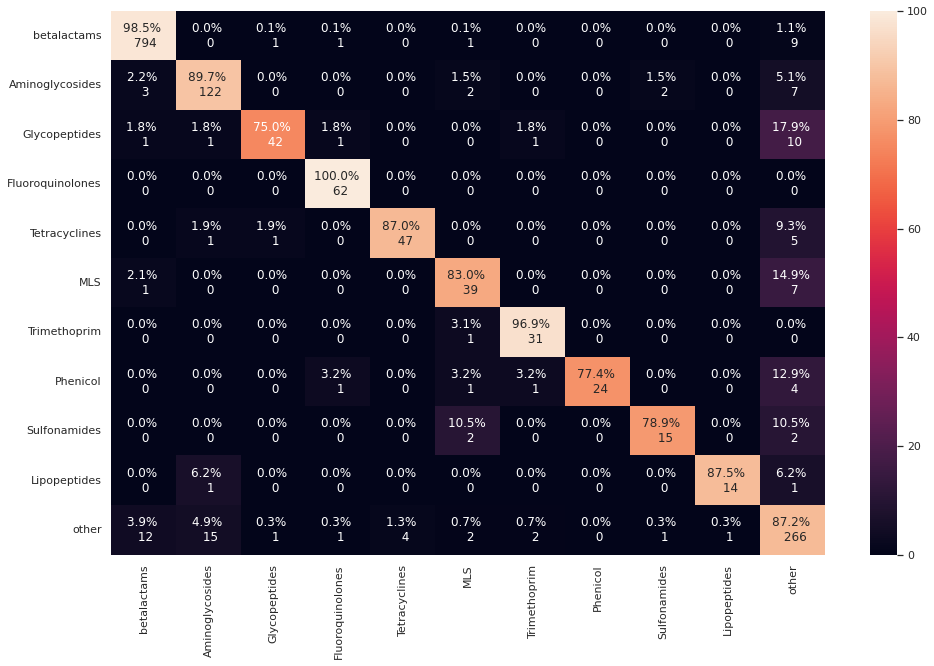

In [52]:
sns.set(rc = {'figure.figsize':(16,10)})
fig, ax = plt.subplots()
sns.heatmap(cmat_perc, annot=labels, fmt="",  ax=ax, yticklabels=(label_code_1.keys()),
            xticklabels=label_code_1.keys())
plt.show()

In [53]:
cmat = confusion_matrix(true_labels_mechanism, pred_labels_mechanism)
shape = cmat.shape
cmat_sum = cmat.sum(1).reshape((-1, 1))
cmat_perc = cmat*100/cmat_sum
labels = (np.asarray(["{1:.1f}% \n {0:.0f}".format(num, perc)
                      for num, perc in zip(cmat.flatten(),
                                               cmat_perc.flatten())])).reshape(shape)

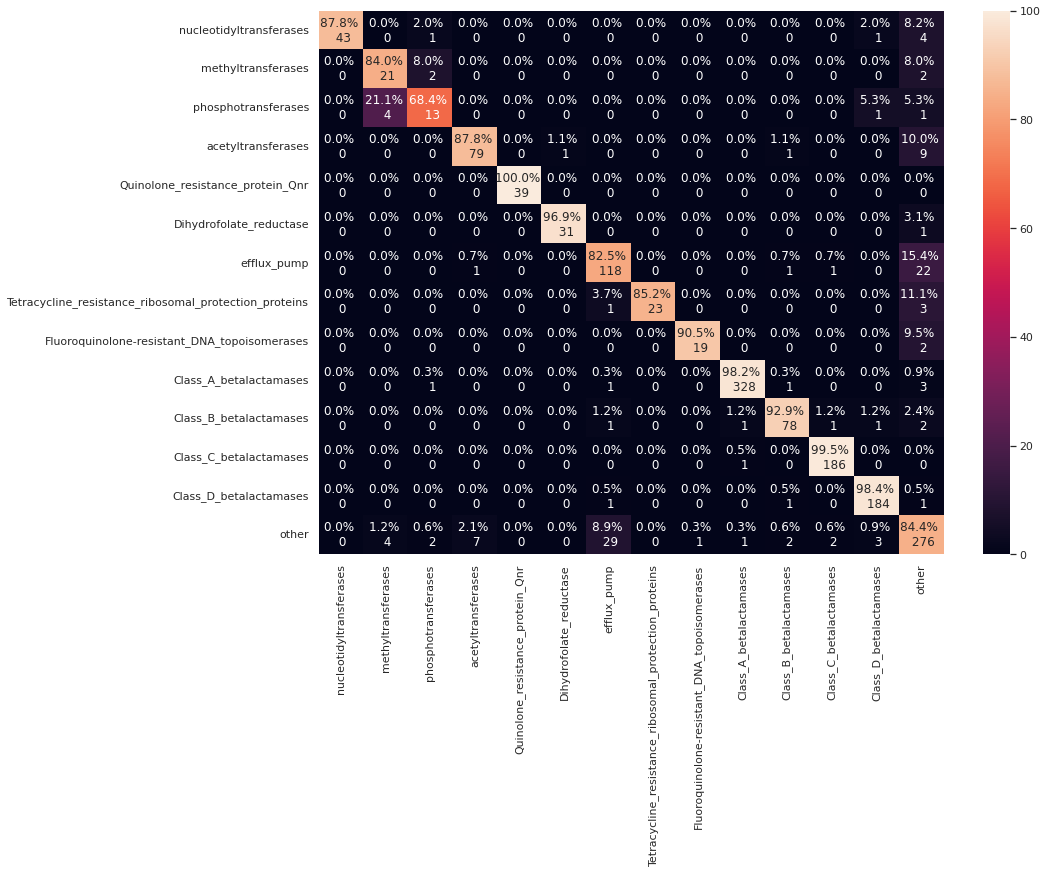

In [54]:
sns.set(rc = {'figure.figsize':(14,10)})
fig, ax = plt.subplots()
sns.heatmap(cmat_perc, annot=labels, fmt="",  ax=ax, yticklabels=(label_code_2.keys()),
            xticklabels=label_code_2.keys())
plt.show()

### Visualizing UMAP

####Dense 1 embedding (Drug class prediction)

In [55]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense1[:-2])
model_cut

Sequential(
  (0): Embedding(5, 10)
  (1): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=14, bias=True)
  )
  (8): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [56]:

embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

       
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        


In [57]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5629, 14), (5629, 2))

In [58]:
label_value = [list(label_code_1.keys())[list(label_code_1.values()).index(p[0])] for p in label_list]

In [59]:
df_embedding = pd.DataFrame(data = (embedding_list))
df_embedding.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,19.320415,-6.225734,-1.39943,-9.173612,-1.849134,1.542628,-19.233587,-4.869513,-3.888136,-4.225414,5.181358,-17.598431,-18.50119,-18.245035


In [60]:
fit = umap.UMAP()
reduced_embedding = fit.fit_transform(df_embedding)

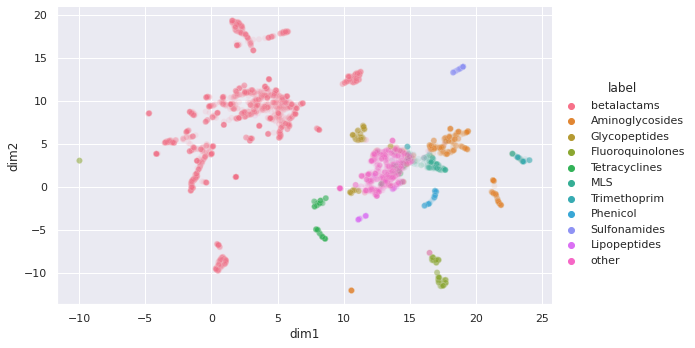

In [61]:
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["label"] = np.array(label_value)
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='label', hue_order=label_code_1.keys(), aspect=1.61, alpha = 0.1)
plt.show()

####Dense 2 embedding (Drug Mechanism)

In [62]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense2[:-2])
model_cut

Sequential(
  (0): Embedding(5, 10)
  (1): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=14, bias=True)
  )
  (8): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [63]:
# model_cut = nn.Sequential(*[model.children for i in range(1)])
# model_cut
embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

        # print(x.shape)
        # Apply pooling
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        
            # validate your model on each batch here

In [64]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5629, 14), (5629, 2))

In [65]:
label_value1 = [list(label_code_1.keys())[list(label_code_1.values()).index(p[0])] for p in label_list]
label_value2 = [list(label_code_2.keys())[list(label_code_2.values()).index(p[1])] for p in label_list]

In [66]:
df_embedding = pd.DataFrame(data = (embedding_list))
df_embedding.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,22.4175,-6.025713,-3.345821,-10.539256,-3.059129,-0.203734,-25.793627,-6.607749,-3.118673,-5.629446,7.331938,-19.694031,-22.34153,-22.803909


In [67]:
fit = umap.UMAP()
reduced_embedding = fit.fit_transform(df_embedding)

In [68]:
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["drug class"] = np.array(label_value1)
reduced_embedding["drug mechanism"] = np.array(label_value2)

# sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
#                 hue='drug class', hue_order=label_code_1.keys(), aspect=1.61, alpha = 0.1)
# plt.show()

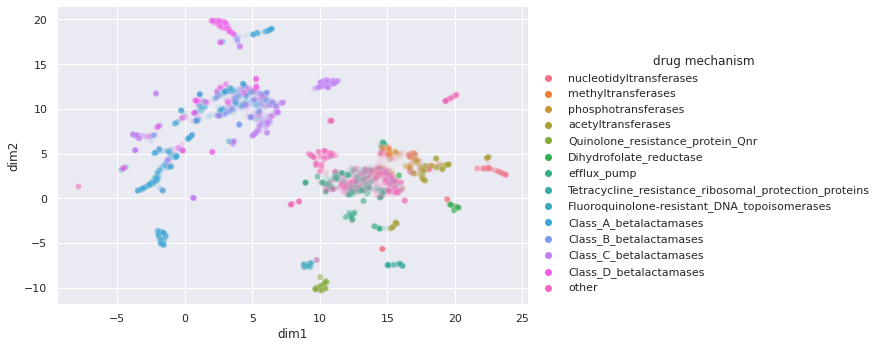

In [69]:
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='drug mechanism', hue_order=label_code_2.keys(), aspect=1.61, alpha = 0.1)
plt.show()

## Multitask Model Baseline

In [70]:
class cnn1d_multitask_baseline(nn.Module):
    def __init__(self, label_count1 = len(label_code_1), label_count2 = len(label_code_2)):
        super(cnn1d_multitask_baseline, self).__init__()
        count = 10
        self.embedding = nn.Embedding(5, count)
        
        self.dense1 = nn.Sequential(nn.Linear(count*2000, label_count1))
        self.dense2 = nn.Sequential(nn.Linear(count*2000, label_count2))

    def forward(self, x):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.embedding(x)
        x = torch.flatten(x, 1)
        x1 = self.dense1(x)
        x2 = self.dense2(x)
        
        return x1, x2

In [71]:
model = cnn1d_multitask_baseline(label_count1=len(label_code_2), label_count2 = len(label_code_2))
model = model.to(device)
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.5*1e-3) 


In [72]:
print("epoch", "train loss", "validation loss")
val_loss_curve = []
train_loss_curve = []

for epoch in range(8):
    
    # Compute train your model on training data
    epoch_loss, train_loss = train_multitask(model, train_dataloader, optimizer,  device=device)
    
    # Validate your on validation data 
    epoch_loss , val_loss = validate_multitask(model, val_dataloader, device=device) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    
    print(epoch, train_loss, val_loss)

epoch train loss validation loss
0 0.7504669 0.512642
1 0.1706351 0.54096484
2 0.09378536 0.4075861
3 0.048064537 0.45269585
4 0.031684104 0.49684146
5 0.03417351 0.48298085
6 0.034535546 0.45127952
7 0.040943485 0.48923573


In [73]:
pred_labels_class = []
pred_labels_mechanism = []
true_labels_class = []
true_labels_mechanism = []
test_loss = 0
with torch.no_grad():
  model.eval()
  for batch in test_dataloader:
    seq, label = batch
    seq = seq.to(device)
    label = label.to(device)
    logits = model(seq)
    loss1 = nn.functional.cross_entropy(logits[0], label.squeeze()[:, 0])# fill in loss here
    loss2 = nn.functional.cross_entropy(logits[1], label.squeeze()[:, 1])
    loss = (loss1+loss2)/2
    test_loss += loss*len(label)
    preds1 = logits[0].max(1).indices
    preds2 = logits[1].max(1).indices
    true_labels_class.extend(list(label.squeeze().detach().cpu().numpy()[:, 0]))
    true_labels_mechanism.extend(list(label.squeeze().detach().cpu().numpy()[:, 1]))

    pred_labels_class.extend(list(preds1.squeeze().detach().cpu().numpy()))
    pred_labels_mechanism.extend(list(preds2.squeeze().detach().cpu().numpy()))
test_loss = test_loss/len(test_data)
test_loss = test_loss.detach().cpu().numpy()
print("Test loss is {}".format(test_loss))
class_acc = (np.array(true_labels_class) ==  np.array(pred_labels_class)).mean()
mechanism_acc = (np.array(true_labels_mechanism) ==  np.array(pred_labels_mechanism)).mean()

print("Test Acc for Class Prediction is {}".format(class_acc))
print("Test Acc for Mechanism Prediction is {}".format(mechanism_acc))

Test loss is 0.4305083751678467
Test Acc for Class Prediction is 0.9315856777493606
Test Acc for Mechanism Prediction is 0.9136828644501279


In [74]:
acc_list_class_mt_bl = []
acc_list_mech_mt_bl = []
test_loss_list_mt_bl = []
for i in tqdm(range(10)):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = i) 
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = i) 
  train_data = SequenceDatasetMultitask(X_train, y_train, labels_dict1 = label_code_1, labels_dict2 = label_code_2)
  val_data = SequenceDatasetMultitask(X_val, y_val, labels_dict1 = label_code_1, labels_dict2 = label_code_2)
  test_data = SequenceDatasetMultitask(X_test, y_test, labels_dict1 = label_code_1, labels_dict2 = label_code_2)

  batch_size = 32
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  model = cnn1d_multitask_baseline(label_count1=len(label_code_2), label_count2 = len(label_code_2))
  model = model.to(device)
  optimizer = torch.optim.Adam(list(model.parameters()), lr=0.5*1e-3) 


  for epoch in range(8):
      
      epoch_loss, train_loss = train_multitask(model, train_dataloader, optimizer,  device=device)
      
      epoch_loss , val_loss = validate_multitask(model, val_dataloader, device=device) 

  pred_labels_class = []
  pred_labels_mechanism = []
  true_labels_class = []
  true_labels_mechanism = []
  test_loss_mt = 0
  with torch.no_grad():
    model.eval()
    for batch in test_dataloader:
      seq, label = batch
      seq = seq.to(device)
      label = label.to(device)
      logits = model(seq)
      loss1 = nn.functional.cross_entropy(logits[0], label.squeeze()[:, 0])# fill in loss here
      loss2 = nn.functional.cross_entropy(logits[1], label.squeeze()[:, 1])
      loss = (loss1+loss2)/2
      test_loss_mt += loss*len(label)
      preds1 = logits[0].max(1).indices
      preds2 = logits[1].max(1).indices
      true_labels_class.extend(list(label.squeeze().detach().cpu().numpy()[:, 0]))
      true_labels_mechanism.extend(list(label.squeeze().detach().cpu().numpy()[:, 1]))

      pred_labels_class.extend(list(preds1.squeeze().detach().cpu().numpy()))
      pred_labels_mechanism.extend(list(preds2.squeeze().detach().cpu().numpy()))
  test_loss_mt = test_loss_mt/len(test_data)
  test_loss_mt = test_loss_mt.detach().cpu().numpy()
  test_loss_list_mt_bl.append(test_loss_mt)
  class_acc = (np.array(true_labels_class) ==  np.array(pred_labels_class)).mean()
  mechanism_acc = (np.array(true_labels_mechanism) ==  np.array(pred_labels_mechanism)).mean()
  acc_list_class_mt_bl.append(class_acc)
  acc_list_mech_mt_bl.append(mechanism_acc)

print("Mean Test loss is {}".format(np.array(test_loss_list_mt_bl).mean()))
print("Mean Test Acc on drug class prediction is {}".format(np.array(acc_list_class_mt_bl).mean()))
print("Mean Test Acc on drug mechanism prediction is {}".format(np.array(acc_list_mech_mt_bl).mean()))

100%|██████████| 10/10 [01:23<00:00,  8.35s/it]

Mean Test loss is 0.5194190740585327
Mean Test Acc on drug class prediction is 0.9064578005115088
Mean Test Acc on drug mechanism prediction is 0.8928388746803069


In [75]:
np.array(test_loss_list_mt_bl).std(), np.array(acc_list_class_mt_bl).std(), np.array(acc_list_mech_mt_bl).std()

(0.055867102, 0.01192433815623123, 0.009074780050746896)

In [76]:

# Create dataloaders

In [77]:
# Create model

In [78]:
# Train model

In [79]:
# Test model